In [2]:
import math
import dimod
import dwave_networkx as dnx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sympy import *
import minorminer
import networkx as nx
import numpy as np
from dwave.samplers import SimulatedAnnealingSampler
from dwave.system import EmbeddingComposite

In [3]:
topology_chimera = dnx.chimera_graph(16)
topology_pegasus = dnx.pegasus_graph(16)
topology_zephyr = dnx.zephyr_graph(15)

In [4]:
############### erdos renyi ###############

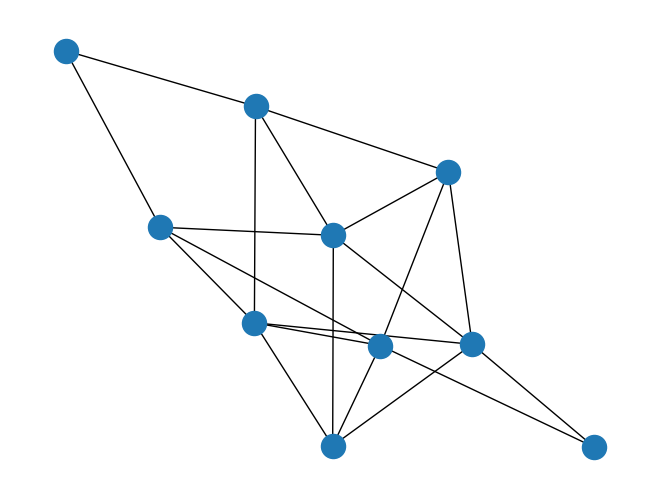

In [130]:
n = 10  # nodes
m = 20  # edges
seed = 20160  # seed random number generators for reproducibility

# Use seed for reproducibility
G = nx.gnm_random_graph(n, m, seed=seed)

pos = nx.spring_layout(G, seed=seed)  # Seed for reproducible layout
nx.draw(G, pos=pos)
plt.show()

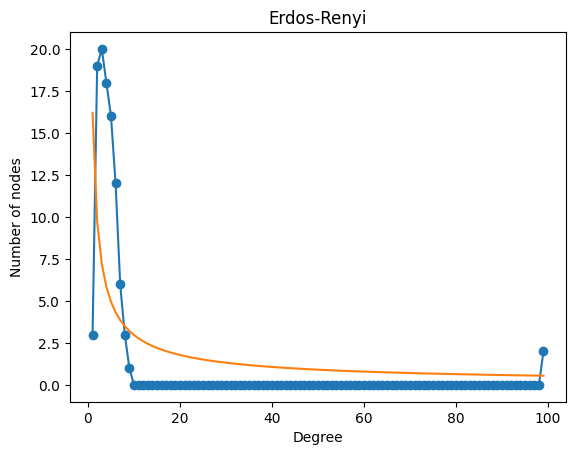

In [95]:
degs = np.arange(1,n)
ns = np.zeros(n-1)

for v in nx.nodes(G):
    ns[nx.degree(G, v)-1] += 1

plt.scatter(degs, ns)
plt.plot(degs, ns)
plt.title("Erdos-Renyi")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")

# best fit
def func(x, a, b):
    return 1 / (a*(x**b))

popt, pcov = curve_fit(func, degs, ns)
fit = func(degs, *popt)
plt.plot(degs, fit)

In [ ]:
############ G(n,p) ############ 

In [ ]:
n = 20  # nodes
samples = 40
ps = np.linspace(0.0, 1.0, samples) # probabilities
k = 4

qubits_chimera = np.zeros(samples)
maxchain_chimera = np.zeros(samples)
qubits_pegasus = np.zeros(samples)
maxchain_pegasus = np.zeros(samples)
qubits_zephyr = np.zeros(samples)
maxchain_zephyr = np.zeros(samples)

for i, p in enumerate(ps):
    G = nx.gnp_random_graph(n, p)

    for j in range(k):
        embedding = minorminer.find_embedding(G, topology_chimera)
        qubits_chimera[i] += sum(map(len, embedding.values()))
        maxchain_chimera[i] += max(map(len, embedding.values()))
        
        embedding = minorminer.find_embedding(G, topology_pegasus)
        qubits_pegasus[i] += sum(map(len, embedding.values()))
        maxchain_pegasus[i] += max(map(len, embedding.values()))

        embedding = minorminer.find_embedding(G, topology_zephyr)
        qubits_zephyr[i] += sum(map(len, embedding.values()))
        maxchain_zephyr[i] += max(map(len, embedding.values()))
    for tensor in [qubits_chimera, maxchain_chimera, qubits_pegasus, maxchain_pegasus, qubits_zephyr, maxchain_zephyr]:
        tensor[i] /= 5
    # print(str(i) + " done")

[0.988591008172803, 0.986770824839178, 0.9847814941816159]


Text(0, 0.5, 'Qubit count')

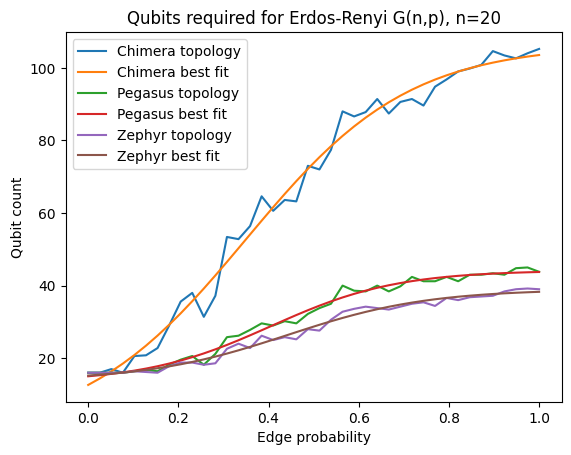

In [28]:
# best fit: S-curve
def logistic(x, L, x_0, k, b):
    return (L / (1 + np.exp(-k * (x - x_0)))) + b

# chimera
L_estimate = qubits_chimera.max()
x_0_estimate = np.median(ps)
k_estimate = 1.0
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, ps, qubits_chimera, p_0)
chimera_fit = logistic(ps, *popt)
plt.plot(ps, qubits_chimera)
plt.plot(ps, chimera_fit)
print("Chimera [L, x_0, k, b]:")
print(*popt)

# pegasus
L_estimate = qubits_pegasus.max()
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, ps, qubits_pegasus, p_0)
pegasus_fit = logistic(ps, *popt)
plt.plot(ps, qubits_pegasus)
plt.plot(ps, pegasus_fit)
print("Pegasus [L, x_0, k, b]:")
print(*popt)

# zephyr
L_estimate = qubits_zephyr.max()
p_0 = [L_estimate, x_0_estimate, k_estimate, n]
    
popt, pcov = curve_fit(logistic, ps, qubits_zephyr, p_0)
zephyr_fit = logistic(ps, *popt)
plt.plot(ps, qubits_zephyr)
plt.plot(ps, zephyr_fit)
print("Zephyr [L, x_0, k, b]:")
print(*popt)

# test correlation
corr_matrices = [np.corrcoef(qubits_chimera, chimera_fit), np.corrcoef(qubits_pegasus, pegasus_fit), np.corrcoef(qubits_zephyr, zephyr_fit)]
corrs = [matrix[0,1] for matrix in corr_matrices]
R_sq = [corr**2 for corr in corrs]
print(R_sq)

plt.legend(["Chimera topology", "Chimera best fit", "Pegasus topology", "Pegasus best fit", "Zephyr topology", "Zephyr best fit"])
plt.title("Qubits required for Erdos-Renyi G(n,p), n=20")
plt.xlabel("Edge probability")
plt.ylabel("Qubit count")

In [ ]:
############ G(n,M) ############ 

In [ ]:
####### vary M #######

In [ ]:
n = 100  # nodes
m1 = 10
m2 = 200
ms = np.arange(m1, m2) # edges
k = 5

qubits_chimera = np.zeros_like(ms)
maxchain_chimera = np.zeros_like(ms)

for m in ms:
    G = nx.gnm_random_graph(n, m)

    for j in range(k):
        embedding = minorminer.find_embedding(G, topology_chimera)
        qubits_chimera[m-m1] += sum(map(len, embedding.values()))
        maxchain_chimera[m-m1] += max(map(len, embedding.values()))
    for tensor in [qubits_chimera, maxchain_chimera]:
        tensor[m-m1] /= 5
    # print(str(m) + " done")

In [ ]:
qubits_pegasus = np.zeros_like(ms)
maxchain_pegasus = np.zeros_like(ms)

for m in ms:
    G = nx.gnm_random_graph(n, m)

    for j in range(k):
        embedding = minorminer.find_embedding(G, topology_pegasus)
        qubits_pegasus[m-m1] += sum(map(len, embedding.values()))
        maxchain_pegasus[m-m1] += max(map(len, embedding.values()))
    for tensor in [qubits_pegasus, maxchain_pegasus]:
        tensor[m-m1] /= k
    # print(str(m) + " done")

In [ ]:
qubits_zephyr = np.zeros_like(ms)
maxchain_zephyr = np.zeros_like(ms)

for m in ms:
    G = nx.gnm_random_graph(n, m)

    for j in range(k):
        embedding = minorminer.find_embedding(G, topology_zephyr)
        qubits_zephyr[m-m1] += sum(map(len, embedding.values()))
        maxchain_zephyr[m-m1] += max(map(len, embedding.values()))
    for tensor in [qubits_zephyr, maxchain_zephyr]:
        tensor[m-m1] /= k
    # print(str(m) + " done")

Text(0, 0.5, 'Qubit count')

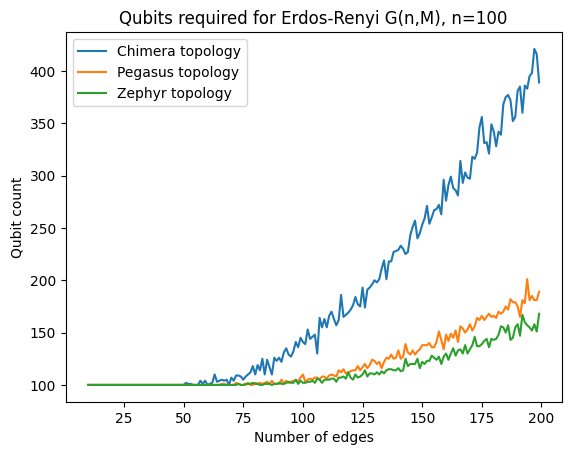

In [183]:
plt.plot(ms, qubits_chimera)
plt.plot(ms, qubits_pegasus)
plt.plot(ms, qubits_zephyr)

plt.legend(["Chimera topology", "Pegasus topology", "Zephyr topology"])
plt.title("Qubits required for Erdos-Renyi G(n,M), n=100")
plt.xlabel("Number of edges")
plt.ylabel("Qubit count")

nqubits = 0.011904048584987396*M^2 + -0.8297501531566861*M + 106.10998426166412
nqubits = 0.005193809221215336*M^2 + -0.6982388268470561*M + 123.3386747766445
nqubits = 0.00442178976619858*M^2 + -0.7175738030226063*M + 130.01285966471931


Text(0, 0.5, 'Qubit count')

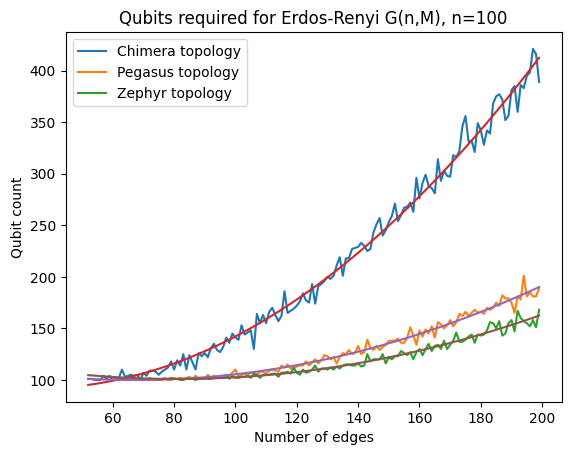

In [185]:
c = 42
c_tail = ms[c:]

p = 51
p_tail = ms[p:]

z = 64
z_tail = ms[z:]

# 52nd is first > 0
chimera_tail = qubits_chimera[c:]
plt.plot(c_tail, chimera_tail)

# 61st is first > 0
pegasus_tail = qubits_pegasus[p:]
plt.plot(p_tail, pegasus_tail)

# 74th is first > 0
zephyr_tail = qubits_zephyr[z:]
plt.plot(z_tail, zephyr_tail)


# best fit: poly 2
a, b, c = np.polyfit(c_tail, chimera_tail, 2)
chimera_fit = a*m_tail*m_tail + b*m_tail + c
plt.plot(m_tail, chimera_fit)
print("nqubits = " + str(a) + "*M^2 + " + str(b) + "*M + " + str(c))

a, b, c = np.polyfit(p_tail, pegasus_tail, 2)
pegasus_fit = a*m_tail*m_tail + b*m_tail + c
plt.plot(m_tail, pegasus_fit)
print("nqubits = " + str(a) + "*M^2 + " + str(b) + "*M + " + str(c))

a, b, c = np.polyfit(z_tail, zephyr_tail, 2)
zephyr_fit = a*m_tail*m_tail + b*m_tail + c
plt.plot(m_tail, zephyr_fit)
print("nqubits = " + str(a) + "*M^2 + " + str(b) + "*M + " + str(c))


# # test correlation
# corr_matrices = [np.corrcoef(chimera_tail, chimera_fit), np.corrcoef(pegasus_tail, pegasus_fit), np.corrcoef(zephyr_tail, zephyr_fit)]
# corrs = [matrix[0,1] for matrix in corr_matrices]
# R_sq = [corr**2 for corr in corrs]
# print(R_sq)

plt.legend(["Chimera topology", "Pegasus topology", "Zephyr topology"])
plt.title("Qubits required for Erdos-Renyi G(n,M), n=100")
plt.xlabel("Number of edges")
plt.ylabel("Qubit count")

In [ ]:
####### vary n #######

In [ ]:
m = 100  # edges
n1 = 12
n2 = 200
ns = np.arange(n1, n2) # nodes
k = 3

qubits_chimera = np.zeros_like(ns)
maxchain_chimera = np.zeros_like(ns)

for n in ns:
    G = nx.gnm_random_graph(n, m)

    for j in range(k):
        embedding = minorminer.find_embedding(G, topology_chimera)
        qubits_chimera[n-n1] += sum(map(len, embedding.values()))
        maxchain_chimera[n-n1] += max(map(len, embedding.values()))
    for tensor in [qubits_chimera, maxchain_chimera]:
        tensor[n-n1] /= k
    print(str(n) + " done")

In [ ]:
qubits_pegasus = np.zeros_like(ns)
maxchain_pegasus = np.zeros_like(ns)

for n in ns:
    G = nx.gnm_random_graph(n, m)

    for j in range(k):
        embedding = minorminer.find_embedding(G, topology_pegasus)
        qubits_pegasus[n-n1] += sum(map(len, embedding.values()))
        maxchain_pegasus[n-n1] += max(map(len, embedding.values()))
    for tensor in [qubits_pegasus, maxchain_pegasus]:
        tensor[n-n1] /= k
    print(str(n) + " done")

In [ ]:
qubits_zephyr = np.zeros_like(ns)
maxchain_zephyr = np.zeros_like(ns)

for n in ns:
    G = nx.gnm_random_graph(n, m)

    for j in range(k):
        embedding = minorminer.find_embedding(G, topology_zephyr)
        qubits_zephyr[n-n1] += sum(map(len, embedding.values()))
        maxchain_zephyr[n-n1] += max(map(len, embedding.values()))
    for tensor in [qubits_zephyr, maxchain_zephyr]:
        tensor[n-n1] /= k
    print(str(n) + " done")

Text(0, 0.5, 'Qubit count')

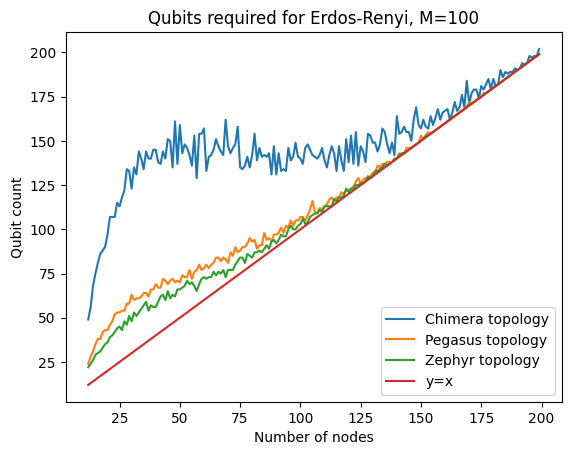

In [129]:
plt.plot(ns, qubits_chimera)
plt.plot(ns, qubits_pegasus)
plt.plot(ns, qubits_zephyr)
plt.plot(ns,ns)

# # best fit: exponential
# def func(x, a, b):
#     return a**x + b
# popt, pcov = curve_fit(func, ms, qubits_chimera)
# chimera_fit = func(ms, *popt)
# plt.plot(ms, chimera_fit)

# # best fit: poly 2
# a, b, c = np.polyfit(ms, qubits_chimera, 2)
# chimera_fit = a*ms*ms + b*ms + c
# plt.plot(ms, chimera_fit)
# # print("nqubits = " + str(a) + "*deg^2 + " + str(b) + "*deg + " + str(c))

# # test correlation
# corr_matrices = [np.corrcoef(qubits_chimera, chimera_fit)]
# corrs = [matrix[0,1] for matrix in corr_matrices]
# R_sq = [corr**2 for corr in corrs]
# print(R_sq)

plt.legend(["Chimera topology", "Pegasus topology", "Zephyr topology", "y=x"])
plt.title("Qubits required for Erdos-Renyi, M=100")
plt.xlabel("Number of nodes")
plt.ylabel("Qubit count")

In [ ]:
############### power law tree ###############

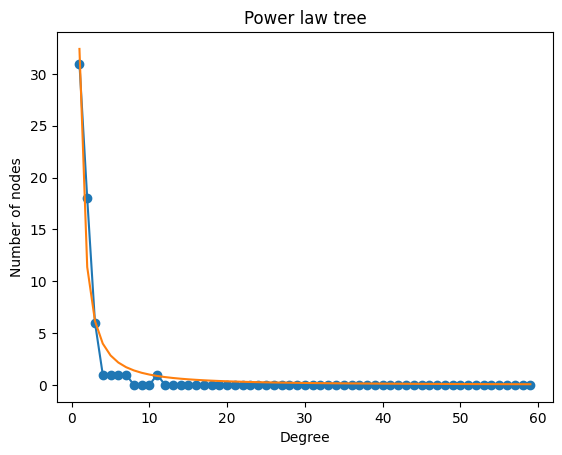

In [71]:
n = 60
degs = np.arange(1,n)
ns = np.zeros(n-1)
G = nx.random_powerlaw_tree(n=n)

for v in nx.nodes(G):
    ns[nx.degree(G, v)-1] += 1

plt.scatter(degs, ns)
plt.plot(degs, ns)
plt.title("Power law tree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")

# best fit
def func(x, a, b):
    return 1 / (a*(x**b))

popt, pcov = curve_fit(func, degs, ns)
fit = func(degs, *popt)
plt.plot(degs, fit)

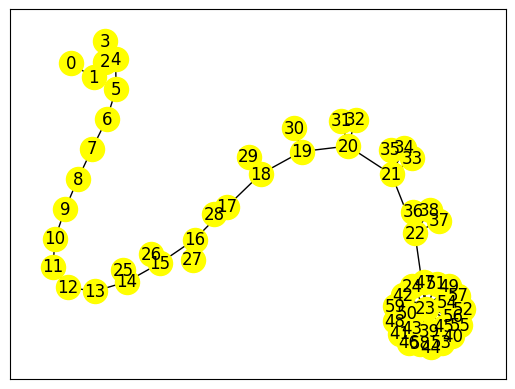

In [31]:
nx.draw_networkx(
    G,
    node_color='yellow',
    # with_labels=False,
    edge_color=['black'],
)